In [32]:
import numpy as np 

import env
from _directions import DIRECTIONS_D6_21201

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [33]:
def sobol(n, d): 
    ''' generate n sobol random vectors of dimension d
    '''
    # v_l = max number of bits needed
    v_l = np.int64(np.ceil(np.log(n) / np.log(2.0)))
    inv2p32 = np.exp(-32.0 * np.log(2.0))

    # v_c[i] = index from the right of the first zero bit of i
    v_c = np.ndarray(n, dtype=np.int64)
    v_c[0] = 1
    for i in range(1, n):
        v_c[i] = 1
        value = i
        while value & 1:
            value >>= 1
            v_c[i] += 1

    # output[i][j] = the jth component of the ith point
    #                with i indexed from 0 to N-1 and j indexed from 0 to D-1
    output = np.ndarray((n, d), dtype=np.float64)
    output.fill(0.0)

    # ----- Compute the first dimension -----

    # Compute direction numbers V[1] to V[L], scaled by pow(2,32)
    v_v = np.ndarray(n, dtype=np.int64)
    for i in range(0, v_l + 1):
        v_v[i] = 1 << (32 - i)

    # Evalulate X[0] to X[N-1], scaled by pow(2,32)
    v_x = np.ndarray(n, dtype=np.int64)
    v_x[0] = 0
    for i in range(1, n):
        v_x[i] = v_x[i - 1] ^ v_v[v_c[i - 1]]
        # Value for vector #i dimension #j==0
        output[i][0] = np.float64(v_x[i]) * inv2p32

    # ----- Compute the remaining dimensions -----
    for j in range(1, d):
        # d_s is the degree of the primitive polynomial
        d_s = DIRECTIONS_D6_21201[j - 1][1]
        # d_a is the number representing the coefficient
        d_a = DIRECTIONS_D6_21201[j - 1][2]
        # d_m is the list of initial direction numbers
        d_m = [0] + DIRECTIONS_D6_21201[j - 1][3:]


        if v_l <= d_s:
            for i in range(1, v_l + 1):
                v_v[i] = d_m[i] << (32 - i)
        else:
            for i in range(1, d_s + 1):
                v_v[i] = d_m[i] << (32 - i)
            for i in range(d_s + 1, v_l + 1):
                v_v[i] = v_v[i - d_s] ^ (v_v[i - d_s] >> d_s)
                for k in range(1, d_s):
                    v_v[i] ^= (((d_a >> (d_s - 1 - k)) & 1) * v_v[i - k])

        v_x[0] = 0
        for i in range(1, n):
            v_x[i] = v_x[i - 1] ^ v_v[v_c[i - 1]]
            output[i][j] = np.float64(v_x[i]) * inv2p32
    # Skip first 0,...,0
    return output[1:]


In [57]:
N_random = 4000 
v1 = sobol(N_random, 2)
v2 = np.random.uniform(size=(N_random, 2))

In [1]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(v1[:,0], v1[:,1], s=4, label='Sobol')
sub.scatter(v2[:,0], v2[:,1], s=2, label='Random')
sub.set_xlim([0., 1.])
sub.set_ylim([0., 1.])
leg = sub.legend()
leg.get_frame().set_facecolor('#00FFCC')


NameError: name 'v1' is not defined

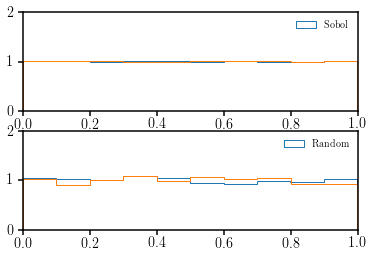

In [59]:
fig = plt.figure()
sub = fig.add_subplot(211)
_ = sub.hist(v1[:,0], histtype='step', normed=True, label='Sobol')
_ = sub.hist(v1[:,1], histtype='step', normed=True)
sub.legend(loc='best')
sub.set_xlim([0., 1.])
sub.set_ylim([0., 2.])
sub = fig.add_subplot(212)
_ = sub.hist(v2[:,0], histtype='step', normed=True, label='Random')
_ = sub.hist(v2[:,1], histtype='step', normed=True)
sub.set_xlim([0., 1.])
sub.set_ylim([0., 2.])
sub.legend(loc='best')